In [27]:
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
def data_preprocess(data_path:str)->pd.DataFrame:
    """
    数据预处理
    :param data_path: 数据路径
    :return: 处理后的数据
    """
    data_raw = pd.read_csv(data_path)   # 读取数据
    data_raw = data_raw.iloc[:, :3] # 去掉时间戳
    data_raw = data_raw.sample(frac=1, random_state=42) # 打乱数据
    return data_raw

In [29]:
data_raw = data_preprocess("ratings.csv")

In [30]:
data_raw

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


In [31]:
def get_data_dict(data:list[list])->dict[int, dict[int, float]]:
    """
    获取数据矩阵
    :param data: 数据
    :return: 数据矩阵
    """
    
    data_dict = {}
    for record in data:
        user = int(record[0])   # 用户名
        movie = int(record[1])  # 电影
        rating = record[2]      # 评分
        if user not in data_dict:
            data_dict[user] = {movie: rating}
        else:
            data_dict[user][movie] = rating
    return data_dict

In [32]:
def k_folds(data:pd.DataFrame, k=10) -> tuple[dict[int, dict[int, float]], dict[int, dict[int, float]]]:
    """
    k折交叉验证
    :param data: 数据
    :param k: 折数
    :return: 训练集和验证集
    """
    data = data.values.tolist()
    each_fold_size = len(data) // k  # 每折的长度
    for i in range(k):
        # 根据循环次数划分不同的训练集和测试集
        if i == k - 1:
            valid = data[i * each_fold_size:]
            train = data[:i * each_fold_size]
        elif i == 0:
            valid = data[: (i + 1) * each_fold_size]
            train = data[(i + 1) * each_fold_size:]
        else:
            valid = data[i * each_fold_size: (i + 1) * each_fold_size]
            train = data[: i * each_fold_size] + data[(i + 1) * each_fold_size :]

        # print(f"第{i+1}折: 训练集长度为{len(train)}, 验证集长度为{len(valid)}")
        yield get_data_dict(train), get_data_dict(valid)

In [33]:
# print(" train_len   valid_len")
for train_matrix, val_matrix in k_folds(data_raw):
    print(len(train_matrix.keys()), len(val_matrix.keys()))

610 603
610 601
610 589
610 602
610 596
610 596
610 601
610 600
610 595
610 600


### 计算皮尔逊系数
![Pearson](PCC.png)

In [34]:
def Pearson(ratings1:list[float], ratings2:list[float]) -> float:
    """
    计算皮尔逊相关系数
    :param ratings1: 用户1的评分
    :param ratings2: 用户2的评分
    :return: 皮尔逊相关系数
    """
    numerator = 0
    denominator1 = 0
    denominator2 = 0
    mean1 = sum(ratings1) / len(ratings1)
    mean2 = sum(ratings2) / len(ratings2)
    for rating1, rating2 in zip(ratings1, ratings2):
        temp1 = rating1 - mean1
        temp2 = rating2 - mean2
        numerator += temp1 * temp2
        denominator1 += temp1 ** 2
        denominator2 += temp2 ** 2
    denominator = (denominator1 * denominator2) ** 0.5
    return numerator / denominator if denominator != 0 else None

In [35]:
def Cosine(ratings1:list[float], ratings2:list[float]) -> float:
    pass

In [36]:
def Slope_One_Distance(ratings1:list[float], ratings2:list[float])->float:
    pass

In [37]:
from typing import Callable
def calculate_similarity(train_dict:dict, sim_func:Callable=Pearson)->dict:
    """
    计算相似度
    :param train_dict: 训练集
    :param sim_func: 计算相似度的方法
    :return 用户相似度字典
    """
    similarity_dict = {}

    for user1 in train_dict.keys():
        for user2 in train_dict.keys():
            if user1 <= user2:  # 只计算上三角
                continue
            # 计算两个用户评价过的物品交集
            intersection_movies = set(train_dict[user1].keys()) & set(train_dict[user2].keys())
            # 如果交集为空，跳过
            if len(intersection_movies) == 0:
                continue

            ratings1 = [train_dict[user1][movie] for movie in intersection_movies]
            ratings2 = [train_dict[user2][movie] for movie in intersection_movies]

            sim = sim_func(ratings1, ratings2)
            if sim is None:
                continue

            # 如果使用Pearson或Cosine相似度，矩阵是对称的
            similarity_dict.setdefault(user1, {})[user2] = sim
            
            # 如果是slope one距离，use1和user2的距离 与 user2和user1的距离 是相反数
            if sim_func.__name__ == "Slope_One_Distance":
                sim = -sim

            similarity_dict.setdefault(user2, {})[user1] = sim

    return similarity_dict

In [38]:
for train_dict, val_dict in k_folds(data_raw):
    similarity_dict = calculate_similarity(train_dict, sim_func=Pearson)
    break

In [39]:
similarity_dict[1]

{479: 0.48507125007266605,
 91: 0.10260047482247601,
 292: 0.2546591588533757,
 474: 0.1410624122939058,
 124: 0.630714997055045,
 605: -0.1867612877044381,
 21: 0.3241161864036896,
 542: 0.17275649627027453,
 453: 0.12719059689195023,
 159: 0.18820469568107587,
 109: -0.06785316179351955,
 51: 0.19406068112663177,
 590: 0.2948925427363379,
 153: -0.05415303610738823,
 599: 0.2164614448783925,
 509: 0.19925953422759674,
 263: 0.5328925475070088,
 514: -0.057141891100455124,
 365: 0.25202591209527253,
 580: 0.1598850913560436,
 166: 0.24389179752074786,
 182: 0.15688732083784085,
 376: -0.2541521226262073,
 332: 0.2282498289077966,
 233: 0.1447870715826871,
 28: -0.026595014802784894,
 217: 0.014081700059284493,
 384: -0.06286946134619316,
 313: 0.08960048808357245,
 368: 0.2721848665815347,
 186: -0.08140199552335024,
 410: 0.11055743550291158,
 577: 0.28872785048384497,
 249: 0.32050328019415264,
 246: 0.4278674187355123,
 393: -0.025891911120126166,
 409: 0.13074409009212268,
 18: 0.

### 获取潜在相邻用户

In [40]:
def sort_neighbor(similarity_dict:dict, sim_func:Callable)->dict:
    """
    对相似度字典进行排序
    :param similarity_dict: 相似度字典
    :return: 排序后的相似度字典
    """
    if sim_func.__name__ == "Slope_One_Distance":   # 如果是slope one，不需要排序
        pass
    
    neighbor_dict = {}
    for user, sim_dict in similarity_dict.items():
        neighbor_dict[user] = [user for user, _ in sorted(sim_dict.items(), key=lambda x: x[1], reverse=True)]
    return neighbor_dict
    

In [41]:
neighbor_dict = sort_neighbor(similarity_dict, sim_func=Pearson)

In [42]:
neighbor_dict[1]

[598,
 473,
 487,
 398,
 106,
 550,
 146,
 139,
 366,
 9,
 595,
 511,
 90,
 13,
 535,
 481,
 499,
 568,
 297,
 114,
 530,
 207,
 237,
 162,
 49,
 163,
 445,
 476,
 394,
 488,
 209,
 430,
 543,
 351,
 124,
 44,
 173,
 65,
 248,
 178,
 176,
 574,
 72,
 435,
 99,
 113,
 303,
 421,
 401,
 319,
 218,
 505,
 596,
 344,
 467,
 300,
 47,
 112,
 340,
 201,
 507,
 215,
 263,
 369,
 210,
 575,
 498,
 185,
 55,
 133,
 302,
 168,
 442,
 285,
 135,
 236,
 126,
 375,
 494,
 477,
 526,
 206,
 479,
 431,
 172,
 301,
 323,
 451,
 449,
 348,
 597,
 8,
 350,
 36,
 276,
 75,
 246,
 145,
 283,
 484,
 414,
 521,
 270,
 167,
 389,
 214,
 308,
 189,
 523,
 69,
 512,
 593,
 62,
 418,
 226,
 572,
 338,
 170,
 120,
 138,
 327,
 513,
 316,
 216,
 136,
 552,
 540,
 160,
 76,
 199,
 57,
 212,
 119,
 20,
 555,
 464,
 379,
 122,
 242,
 314,
 536,
 456,
 510,
 448,
 434,
 287,
 608,
 312,
 192,
 171,
 266,
 600,
 504,
 21,
 100,
 249,
 385,
 268,
 244,
 155,
 200,
 590,
 307,
 577,
 447,
 19,
 524,
 483,
 165,
 412,
 8

### 计算训练集中每个用户的平均分

In [43]:
def avg(train_dict:dict)->dict[int, float]:
    """
    计算每个用户的平均评分
    :param train_dict: 训练集
    :return: 用户的平均评分
    """
    avg_dict = {}
    for user, movie_dict in train_dict.items():
        avg_dict[user] = sum(movie_dict.values()) / len(movie_dict)
    return avg_dict

In [44]:
avg_dict = avg(train_dict)

In [45]:
avg_dict[1]

4.333333333333333

### 预测评分
![predict](predict.png)

In [46]:
from typing import Optional
def predict(train_dict:dict, val_dict:dict,
            similarity_dict:dict, avg_dict:dict, 
            neighbor_dict:dict, neighbor_num:Optional[int]=None,
            sim_func:Callable=Pearson)->dict[int, dict[int, float]]:
    """
    预测评分
    :param train_dict: 训练集 {user: {movie: rating}
    :param val_dict: 验证集 {user: {movie: rating}
    :param similarity_dict: 相似度字典 {user1: {user2: sim}
    :param neighbor_dict: 排序后的邻居 {user: [neighbor1, neighbor2, ...]}
    :param avg_dict: 用户的平均评分 {user: avg}
    :param neighbor_num: 邻居数量,当sim_func为slope one时, 不使用
    :sim_func: 相似度计算方法
    :return: 预测评分
    """

    predict_dict = {}
    for user in val_dict.keys():
        to_predict_movies = val_dict[user].keys()   # 需要预测的电影

        # 如果用户不在训练集中，预测为3.5, 作为默认值
        if user not in train_dict.keys():
            predict_dict[user] = {movie: 3.5 for movie in to_predict_movies}
            continue
        # 如果用户没有邻居，取平均值作为预测值
        if user not in neighbor_dict.keys():
            predict_dict[user] = {movie: avg_dict[user] for movie in to_predict_movies}
            continue

        neighbors = neighbor_dict[user] # 用户的邻居
        # 遍历需要预测的电影
        for movie in to_predict_movies:
            numerator = 0
            denominator = 0
            neighbors_now = 0   # 记录当前使用的相邻用户的个数

            # 遍历邻居
            for neighbor in neighbors:
                # 如果邻居没有看过该电影，跳过
                if movie not in train_dict[neighbor].keys():
                    continue
                
                neighbors_now += 1  
                
                if sim_func==Slope_One_Distance:    # 如果使用slope one
                    pass
                else:   # 如果不使用slope one
                    numerator += similarity_dict[user][neighbor] * (train_dict[neighbor][movie] - avg_dict[neighbor])
                    denominator += abs(similarity_dict[user][neighbor])
                    # 如果已使用的邻居数量已达到要求，则跳出循环
                    if neighbors_now >= neighbor_num:
                        break
            
            if sim_func==Slope_One_Distance:    # 如果使用slope one
                pass
            else:   # 如果不使用slope one
                predict_rating = avg_dict[user] + numerator / denominator if denominator != 0 else avg_dict[user]

            predict_dict.setdefault(user, {})[movie] = predict_rating

    return predict_dict

In [47]:
predict_dict = predict(train_dict, val_dict, similarity_dict, avg_dict, neighbor_dict, neighbor_num=100, sim_func=Pearson)

In [48]:
predict_dict[1]

{3740: 4.855594643561714,
 2353: 4.090941991510582,
 1278: 4.688578697347683,
 596: 4.424570800562546,
 2115: 4.426832050433728,
 2529: 4.663405717794239,
 1927: 4.568271937053053,
 2078: 4.718920383913993,
 3034: 4.766105948602876,
 2899: 4.570833333333333,
 1500: 4.49870265854952,
 1198: 5.018897959022121,
 1587: 4.47949556893574,
 1029: 4.503062254740216,
 423: 3.6805404717406693,
 2492: 3.905844594877709,
 2048: 4.326025637962659,
 2797: 4.442887289128326,
 3578: 4.7228963967319135,
 2991: 4.907596664062714,
 1580: 4.1525760308418045,
 2640: 4.390361227958985,
 2387: 4.69272669788001,
 1954: 4.821013653299108,
 2459: 4.01194207102159}

In [49]:
def MAE(predict_dict:dict[int, dict[int, float]], val_dict:dict[int, dict[int, float]])->float:
    """
    计算MAE
    :param predict_dict: 预测评分
    :param val_dict: 验证集
    :return: MAE
    """
    error = 0
    predict_nums = 0
    for user in val_dict.keys():
        for movie in val_dict[user].keys():
            error += abs(predict_dict[user][movie] - val_dict[user][movie])
            predict_nums += 1
    return error / predict_nums

In [50]:
MAE(predict_dict, val_dict)

0.6842993991862886

# 完整流程(Pearson)

In [51]:
def user_based_CF(data_path:str, fold_num:int,neighbor_num:Optional[int]=None, sim_func:Callable=Pearson, log:bool=True)->float:
    """
    基于用户的协同过滤
    :param data_path: 数据路径
    :param fold_num: 折数
    :param neighbor_num: 邻居数量, 可选, 当使用slope one时, 不使用
    :param sim_func: 相似度计算方法, Pearson, Cosine, Slope One
    :param log: 是否打印日志
    """
    data_raw = data_preprocess(data_path)

    MAE_list = []
    for i, (train_dict, val_dict) in enumerate(k_folds(data_raw, fold_num)):
        # 计算相似度
        similarity_dict = calculate_similarity(train_dict, sim_func=sim_func)
        # 计算每个用户的平均评分
        avg_dict = avg(train_dict)
        # 对相似度字典进行排序
        neighbor_dict = sort_neighbor(similarity_dict, sim_func=sim_func)
        # 预测评分
        predict_dict = predict(train_dict, val_dict, 
                               similarity_dict, avg_dict, neighbor_dict, 
                               neighbor_num=neighbor_num, sim_func=sim_func)
        
        MAE_list.append(MAE(predict_dict, val_dict))
        if log:
            print(f"第{i+1}折  MAE: {MAE_list[-1]}")
    
    return sum(MAE_list) / len(MAE_list)

In [52]:
print(Slope_One_Distance.__name__)
user_based_CF("ratings.csv", fold_num=10, neighbor_num=100, sim_func=Pearson, log=True)

Slope_One_Distance
第1折  MAE: 0.6842993991862886
第2折  MAE: 0.6637121444115034
第3折  MAE: 0.6656553979086914
第4折  MAE: 0.6705654527152669
第5折  MAE: 0.675643260832692
第6折  MAE: 0.6595833733332681
第7折  MAE: 0.673776275790296
第8折  MAE: 0.6693624500300098
第9折  MAE: 0.6714693397858811
第10折  MAE: 0.6812036134696777


0.6715270707463575

In [55]:
import time
neighbor_nums = [i for i in range(1,11)] + [i for i in range(11, 32, 2)] + [i for i in range(35, 201, 5)]
mae_list = []
start_time = time.time()
for neighbor_num in neighbor_nums:
    mae = user_based_CF("ratings.csv", fold_num=5, neighbor_num=neighbor_num, sim_func=Pearson, log=False)
    mae_list.append(mae)
    print(f"neighbor: {neighbor_num}   MAE: {mae}   time: {time.time() - start_time}")

neighbor: 1   MAE: 0.90885955109982   time: 18.153594732284546
neighbor: 2   MAE: 0.7969503068906049   time: 36.40606617927551
neighbor: 3   MAE: 0.7526322229641348   time: 54.91667056083679
neighbor: 4   MAE: 0.7306001089910732   time: 74.29477119445801
neighbor: 5   MAE: 0.7173343703133901   time: 94.2137393951416
neighbor: 6   MAE: 0.7080311339638594   time: 114.4890205860138
neighbor: 7   MAE: 0.7016829645101357   time: 134.98500633239746
neighbor: 8   MAE: 0.697019471153714   time: 155.3727650642395
neighbor: 9   MAE: 0.6935035832473255   time: 174.52913188934326
neighbor: 10   MAE: 0.690741214276655   time: 193.69649362564087
neighbor: 11   MAE: 0.6888915163067503   time: 213.11905527114868
neighbor: 13   MAE: 0.6857855916722471   time: 232.62950372695923
neighbor: 15   MAE: 0.6836694583888605   time: 252.42201614379883
neighbor: 17   MAE: 0.6821230712587829   time: 272.4035613536835
neighbor: 19   MAE: 0.6811571183043282   time: 292.777215719223
neighbor: 21   MAE: 0.68028580498

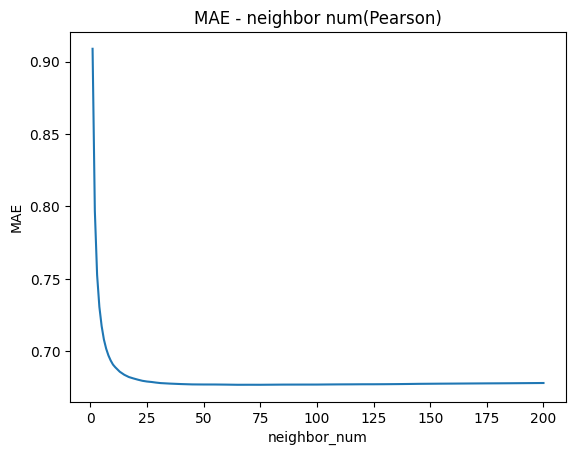

In [56]:
plt.plot(neighbor_nums, mae_list)
plt.xlabel("neighbor_num")
plt.ylabel("MAE")
plt.title("MAE - neighbor num(Pearson)")
plt.show()